## Loan default probability

Lenders provide loans to borrowers in exchange for the promise of repayment with interest. That means the lender makes a profit only if the borrower pays off the loan. Hence, the two most critical questions in the lending industry are:
- how risky is the borrower?
- given the borrower's risk, should we lend to them?

The goal of this case study is to build a machine learning model to predict the proba‐ bility that a loan will default. In most real-life cases we are unable to work with clean, complete data. Some of the potential problems we are bound to encounter are missing values, incomplete categorical data, and irrelevant features. Data cleaning is critical for the success of machine learning applications like this one.

The target variable is *charge-off*, a debt that a creditor has given up trying to collect on after a borrower has missed payments for several months. The predicted variable takes a value of 1 in case of charge-off and a value of 0 otherwise. 

The dataset contains data for loans from 2007 to 2020 from a peer-to-peer lending company called Lending Club. The dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/marcusos/lending-club-clean).

In [6]:
import pandas as pd
#pip install pyarrow

dataset = pd.read_feather('./data/loans/lending_club_clean.feather')

In [9]:
dataset.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000,5000,4975.0,36,0.1065,162.869995,B,B2,NaN,...,NaT,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N
1,1077430,2500,2500,2500.0,60,0.1527,59.830002,C,C4,Ryder,...,NaT,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N
2,1077175,2400,2400,2400.0,36,0.1596,84.330002,C,C5,NaN,...,NaT,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N
3,1076863,10000,10000,10000.0,36,0.1349,339.309998,C,C1,AIR RESOURCES BOARD,...,NaT,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N
4,1075358,3000,3000,3000.0,60,0.1269,67.790001,B,B5,University Medical Group,...,NaT,NaT,NaT,-1,-1,NaN,-1.0,-1.0,-1.0,N


### Data Preparation and Feature Selection

In [11]:
# We're going to try to predict the loan_status variable. What are the value counts for this variable
dataset['loan_status'].value_counts(dropna=False) 

loan_status
Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: count, dtype: int64

We're interested only in the two categories "fully-paid" and "charged-off" in order to have a binary classification problem.

In [12]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

dataset['loan_status'].value_counts(dropna=False)

dataset['loan_status'].value_counts(normalize=True, dropna=False)

loan_status
Fully Paid                                             0.805116
Charged Off                                            0.194884
Current                                                0.000000
Default                                                0.000000
Does not meet the credit policy. Status:Charged Off    0.000000
Does not meet the credit policy. Status:Fully Paid     0.000000
In Grace Period                                        0.000000
Issued                                                 0.000000
Late (16-30 days)                                      0.000000
Late (31-120 days)                                     0.000000
Name: proportion, dtype: float64

About 80.5% of the remainig loans have been fully paid and 19.5% have been charged off, so we have a slightly unbalanced classification problem. Now we create a binary column in the dataset, where we categorize fully-paid as 0 and charged-off as 1.

In [14]:
import numpy as np
# 'charged-off' will be our target variable
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)

<ipython-input-14-a89f1de5c1b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
<ipython-input-14-a89f1de5c1b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop('loan_status', axis=1, inplace=True)


#### Feature selection

The full dataset has 140 features for each loan, but not all features contribute to the prediction variable. Removing features of low importance can improve accuracy and reduce both model complexity and overfitting. Training time can also be reduced for very large datasets. We’ll eliminate features in the following steps using three different approaches:
- Eliminating features that have more than 30% missing values.
- Eliminating features that are unintuitive based on subjective judgment.
- Eliminating features with low correlation with the predicted variable.

In [19]:
# Compute the missing-data percentage for each feature

missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

next_pymnt_d                 1.000000
hardship_loan_status         0.993182
hardship_status              0.993176
hardship_type                0.993176
payment_plan_start_date      0.993176
hardship_end_date            0.993176
hardship_start_date          0.993176
hardship_reason              0.993175
sec_app_earliest_cr_line     0.968483
verification_status_joint    0.963825
dtype: float64

In [22]:
# Drop columns that have more than 30% of missing data
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
print(drop_list)

['hardship_end_date', 'hardship_loan_status', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'next_pymnt_d', 'payment_plan_start_date', 'sec_app_earliest_cr_line', 'verification_status_joint']


<ipython-input-22-0709dd219227>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(labels=drop_list, axis=1, inplace=True)


#### Feature elimination based on intuitiveness

To filter the features further we check the description in the data dictionary and keep the features that intuitively contribute to the prediction of default. We keep features that contain the relevant credit detail of the borrower, including annual income, FICO score, debt-to-income ratio, loan grade and interest rate. 

In [24]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', \
    'application_type','dti', 'emp_length',\
    'emp_title', 'fico_range_high',\
    'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', \
    'installment', 'int_rate', 'loan_amnt', 'loan_status',\
    'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', \
    'purpose', 'revol_bal', 'revol_util', \
    'sub_grade', 'term', 'title', 'total_acc',\
    'verification_status', 'zip_code','last_pymnt_amnt',\
    'num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op',\
    'mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy",\
    "avg_cur_bal","acc_open_past_24mths" ]

drop_list = [col for col in dataset.columns if col not in keep_list]

# Drop all the columns that are not in the keep-list
dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

<ipython-input-24-38d6c4843056>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(labels=drop_list, axis=1, inplace=True)


(1860331, 39)

#### Feature selection based on the correlation

We check the correlation with the predicted variable and select features with a moderate-to-strong relationship with the target variable and drop those that have a correlation of less than 3% with the predicted variable.


In [27]:
correlation = dataset.corr(numeric_only=True)
correlation_chargeOff = abs(correlation['charged_off'])

correlation_chargeOff.sort_values(ascending=False)

charged_off              1.000000
last_pymnt_amnt          0.329065
int_rate                 0.253294
term                     0.168494
fico_range_low           0.120516
fico_range_high          0.120515
acc_open_past_24mths     0.095231
funded_amnt              0.071946
loan_amnt                0.071915
bc_open_to_buy           0.070527
avg_cur_bal              0.068673
mort_acc                 0.066987
num_actv_rev_tl          0.066615
dti                      0.063828
installment              0.059915
bc_util                  0.056019
revol_util               0.049437
mo_sin_rcnt_rev_tl_op    0.047360
id                       0.043718
mo_sin_old_rev_tl_op     0.041890
pub_rec_bankruptcies     0.027651
pub_rec                  0.023995
annual_inc               0.022470
revol_bal                0.022170
open_acc                 0.021118
total_acc                0.015674
Name: charged_off, dtype: float64

In [28]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
print(drop_list_corr)

['annual_inc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']


In [29]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

<ipython-input-29-611e146d1556>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(labels=drop_list_corr, axis=1, inplace=True)


(1860331, 33)

### Feature Engineering and Exploratory Analysis
#### Analyzing the categorical features
IDs are all unique and irrelevant for modeling. Occupation and job title may provide some information for default modeling; however, we assume much of this information is embedded in the verified income of the customer. Additional cleaning steps on these features, such as standardizing or grouping the titles, would be necessary to extract any marginal information. This work is outside the scope of this case study but could be explored in subsequent iterations of the model. Geography could play a role in credit determination, and zip codes provide a granu‐ lar view of this dimension. Again, additional work would be necessary to prepare this feature for modeling and was deemed outside the scope of this case study.

In [30]:
#Ids are all unique and there are too many job titles and titles and zipcode, 
#these column is dropped The ID is not useful for modeling.
dataset.drop(['id','emp_title','title','zip_code'], axis=1, inplace=True)

<ipython-input-30-dd5686e50453>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(['id','emp_title','title','zip_code'], axis=1, inplace=True)


*Term* refers to the number of payments on the loan. Values are in months and can be either 36 or 60. The 60-month loans are more likely to charge off. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods. This feature seems to be important for the prediction.

In [33]:
# Percentage of charged-off for the two different temporal loans.
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.156242
60    0.310163
Name: proportion, dtype: float64

Let's check the employment length feature:

<ipython-input-36-0752f6a78803>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
<ipython-input-36-0752f6a78803>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)
<ipython-input-36-0752f6a78803>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

<Axes: xlabel='emp_length'>

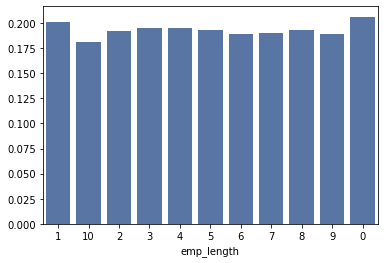

In [36]:
import seaborn as sns

dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(str(s).split()[0])
    
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)


charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

Loan status does not appear to vary much with *employment length* (on average); hence this feature is dropped.

In [37]:
dataset.drop(['emp_length'], axis=1, inplace=True)

<ipython-input-37-5cd6b947b435>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(['emp_length'], axis=1, inplace=True)


Let's check the feature *sub-grade*

<Axes: xlabel='sub_grade'>

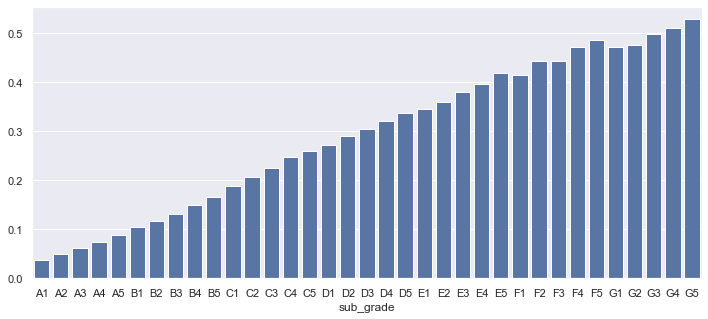

In [38]:
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

There's a clear trend of higher probability of charge-off as the subgrade worsens. For this reason this feature is considered a key-feature.

#### Analyzing continuous features

Let's check FICO score. Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores.

In [44]:
dataset[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [45]:
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']

dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

<ipython-input-45-8b3df8342ff7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']
<ipython-input-45-8b3df8342ff7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)


#### Encoding categorical data

In order to use a feature in the classification models, we need to convert the categorical data (i.e., text features) to its numeric representation. For this case study we will use a label encoder, which encodes labels with a value between 0 and n, where n is the number of distinct labels.

In [53]:
from sklearn.preprocessing import LabelEncoder

# Categorical boolean mask
#categorical_feature_mask = dataset.dtypes==object
categorical_feature_mask = dataset.dtypes=='category'
# filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()
print(categorical_cols)

['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type']


In [54]:
le = LabelEncoder()
# apply the label encoder on categorical feature columns
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))

<ipython-input-54-5989ec303482>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))


#### Sampling data
We see that the target variable is **unbalanced**. For this reason we decide to **sample the data** in order to have an equal number of charge-off and no charge-off observation. Sampling leads to a more bal‐ anced dataset and avoids overfitting but it may exclude some data that might not be homogeneous to the data that is taken. This affects the level of accuracy in the results. Also, selection of the proper size of samples is a difficult job. Hence, sampling should be performed with caution and should generally be avoided in the case of a relatively balanced dataset.


In [55]:
dataset['charged_off'].value_counts()

charged_off
0    1497783
1     362548
Name: count, dtype: int64

In [56]:
loanstatus_0 = dataset[dataset["charged_off"]==0]
loanstatus_1 = dataset[dataset["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (11000, 27)


In [59]:
#Filling the NAs with the mean of the column.
dataset.fillna(dataset.mean(),inplace = True)

### Evaluate Algorithms and Models

In [73]:
from sklearn.model_selection import train_test_split
# Train-test split
Y= dataset["charged_off"]
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [75]:
# k-fold
num_folds = 10
# test options for classification
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

In [76]:
X_train

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,fico_score
7798,25000,25000,36,0.0532,752.869995,0,0,1,0,2,...,0,6,11993,27793,58.000000,173,3,1,12,712.0
3841,10500,10500,60,0.1398,244.210007,2,12,4,2,2,...,0,5,11440,10820,88.300003,278,1,2,15,682.0
522,24000,24000,36,0.0839,756.400024,1,5,1,2,2,...,1,5,56834,18550,42.900002,158,1,3,7,667.0
242,14000,14000,36,0.1199,464.940002,1,7,1,1,2,...,0,6,17569,3790,59.700001,100,2,1,6,707.0
8384,5000,5000,36,0.1894,183.130005,3,16,4,0,2,...,0,7,3840,6119,23.500000,62,16,0,5,677.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,25000,25000,36,0.1299,842.229980,1,8,5,2,2,...,0,5,3433,12324,57.200001,278,0,2,6,722.0
5699,4000,4000,36,0.1099,130.940002,1,7,1,0,1,...,0,3,40618,9598,24.400000,113,24,2,3,712.0
10742,10750,10750,36,0.1649,380.549988,3,17,1,0,2,...,0,5,1420,184,94.099998,66,7,0,8,662.0
537,16000,16000,36,0.1797,578.200012,3,15,5,0,2,...,0,5,10265,419,97.800003,86,13,0,6,662.0


In [78]:
from sklearn.model_selection import KFold, cross_val_score
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.878978 (0.007717)
LDA: 0.888243 (0.009071)
KNN: nan (nan)
CART: 0.804523 (0.006905)
NB: 0.897680 (0.009630)
NN: 0.866557 (0.022019)
AB: 0.926464 (0.005531)
GBM: 0.937575 (0.004772)
RF: 0.928652 (0.005963)
ET: 0.916220 (0.007959)


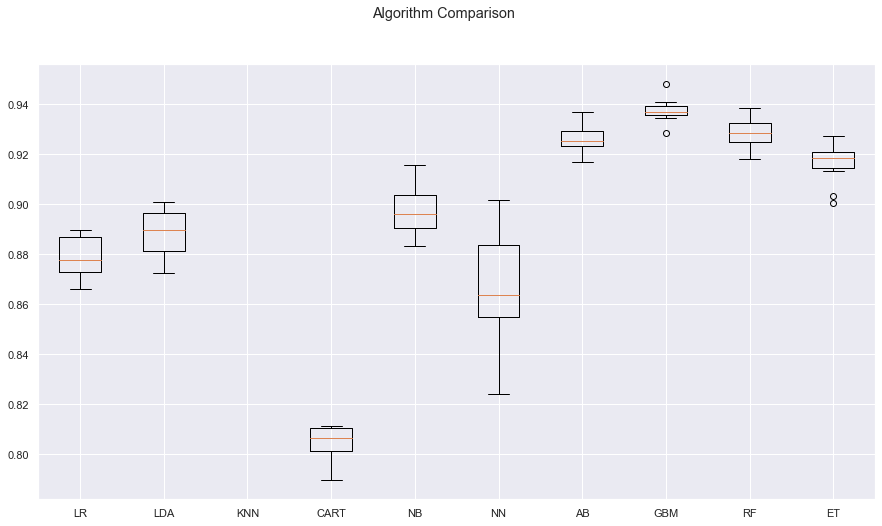

In [80]:
import matplotlib.pyplot as plt
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

### Moodel tuning and grid search
Given that the GBM is the best model, Grid Search is performed on GBM in this step.

In [83]:
from sklearn.model_selection import GridSearchCV
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.939140 using {'max_depth': 3, 'n_estimators': 180}
#4 0.925210 (0.006371) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.939140 (0.004611) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.932152 (0.004292) with: {'max_depth': 5, 'n_estimators': 20}
#2 0.938764 (0.004362) with: {'max_depth': 5, 'n_estimators': 180}


### Finalize the model

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Results on the test dataset
model = GradientBoostingClassifier(max_depth= 3, n_estimators= 180)
model.fit(X_train, Y_train)

# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8668181818181818
[[ 842  226]
 [  67 1065]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1068
           1       0.82      0.94      0.88      1132

    accuracy                           0.87      2200
   macro avg       0.88      0.86      0.87      2200
weighted avg       0.87      0.87      0.87      2200



Accuracy of 88% on the test set is reasonable.

<Axes: xlabel='Predicted', ylabel='Actual'>

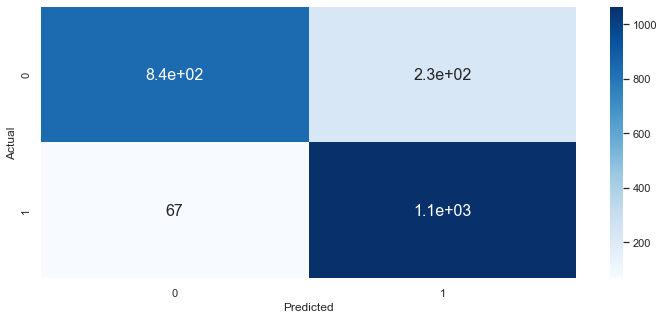

In [89]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

#### Feature importance
Looking at the details above GBM might be worthy of further study. Let us look into the Feature Importance of the GBM model

[4.44566751e-03 4.03771455e-03 4.41314450e-02 3.75900287e-02
 4.69021393e-02 1.96027342e-04 2.93779918e-02 8.08915446e-04
 2.97498491e-04 1.50821486e-03 1.25671667e-03 3.40524131e-03
 4.03174325e-03 1.74766583e-03 7.84223700e-01 8.31333906e-04
 1.19413472e-02 3.88632409e-03 3.50180316e-03 3.06197947e-03
 6.57836917e-03 1.12705292e-03 9.25764846e-04 2.23728929e-03
 1.94802591e-03]


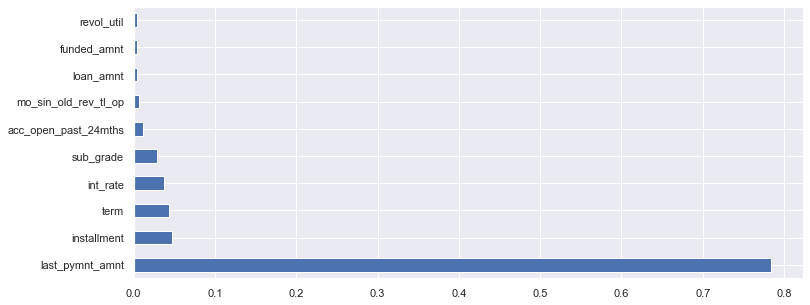

In [90]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The last payment amount seems to be the most important feature, followed by installment, loan term, interest rate and sub-grade.